# Overview
This notebook is intended to demonstrate how to run a differential gene expression analysis between tumor and normal samples using GDC cancer data made available in BigQuery. We will be using the TCGA gene expression dataset in `isb-cgc-bq`, specifically the table `isb-cgc-bq.TCGA.mRNAseq_hg38_gdc_current`. This notebook is modeled to somewhat mirror the differential expression analysis found in Peng, et al. *Scientific Reports* 2015 (https://doi.org/10.1038/srep13413).

First we need to set up the environment and authenticate our session. This notebook will use both python to construct and run our SQL query and the Bioconductor R libraries `edgeR` and `DESeq2`.

In [ ]:
BiocManager::install("DESeq2")

In [2]:
library(DESeq2)
library(edgeR)
library(scales)
library(bigrquery)
project <- 'isb-cgc-outreach'
bigrquery::bq_auth(path = "~/key-file")

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomicRanges

Loading required package: GenomeInfoDb

Loading required package: SummarizedExperiment

Loading required package: MatrixGe

# Finding all cases with data for both normal and tumor aliquots
Our first step is to join sample_type data to our RNA seq table and identify the cases in the RNA seq BigQuery table of choice that have data for both tumor and normal aliquots. To perform this operation we can write an SQL query which groups rows by case barcode and then use the `array_agg()` function to concatenate the `sample_type_name` field for each case. 

In [3]:
rna_table <- "isb-cgc-bq.TCGA.RNAseq_hg38_gdc_current"

case_query <- "
WITH rna as (
    SELECT 
       case_barcode, 
       sample_barcode, 
       aliquot_barcode, 
       Ensembl_gene_id_v, 
       gene_name, 
       HTSeq__Counts,
       HTSeq__FPKM_UQ,
       sample_type_name,
    FROM `isb-cgc-bq.TCGA.RNAseq_hg38_gdc_current`
    WHERE gene_type = 'protein_coding'
    AND project_short_name = 'TCGA-BRCA'
),
cases as (
  SELECT case_barcode, agg FROM
      (SELECT 
        case_barcode, 
        array_agg(distinct sample_type_name) agg
      FROM rna
      GROUP BY case_barcode)
  WHERE array_length(agg) > 1
  AND ('Solid Tissue Normal' in UNNEST(agg))
  )"

select_cases <- "
SELECT * FROM cases
"

#print(paste0(case_query, select_cases))
case_job <- bq_project_query( project, query=paste0(case_query, select_cases) )
case_df <- as.data.frame(bq_table_download(case_job))
head(case_df)

,case_barcode,agg
,<chr>,<list>
1,TCGA-E2-A15K,"Solid Tissue Normal, Metastatic , Primary Tumor"
2,TCGA-AC-A23H,"Primary Tumor , Solid Tissue Normal"
3,TCGA-BH-A1FU,"Primary Tumor , Solid Tissue Normal"
4,TCGA-BH-A204,"Primary Tumor , Solid Tissue Normal"
5,TCGA-E9-A1NG,"Solid Tissue Normal, Primary Tumor"
6,TCGA-A7-A13G,"Solid Tissue Normal, Primary Tumor"


# Subsetting the gene set
Performing a comparison across all genes is outside of the scope of this notebook, so we will reduce our gene set to a more manageable size. A common metric to subset by is the variance of expression level. We can calculate this metric in an SQL query by grouping by the `Ensembl_gene_id_v` field and calculating the `VARIANCE()` of the FPKM_UQ field. We then order our results by this value and select the top 2000 genes.

In [4]:
expression_query <- ",
mean_expr as (
  SELECT * FROM (
    SELECT  
      rna.Ensembl_gene_id_v, 
      VARIANCE(rna.HTSeq__FPKM_UQ) var_fpkm
    FROM rna 
    JOIN cases ON rna.case_barcode = cases.case_barcode 
    WHERE rna.sample_type_name = 'Solid Tissue Normal'
    GROUP BY rna.Ensembl_gene_id_v)
  ORDER BY var_fpkm DESC
  LIMIT 2000)"

select_genes <- "
SELECT * FROM mean_expr
"

expr_job <- bq_project_query( project, query=paste0(case_query, expression_query, select_genes) )
# print( paste0( case_query + expression_query + select_genes ) )
expr_data <- as.data.frame( bq_table_download(expr_job) )
head(expr_data)

,Ensembl_gene_id_v,var_fpkm
,<chr>,<dbl>
1,ENSG00000198886.2,2.008907e+16
2,ENSG00000198938.2,1.707931e+16
3,ENSG00000143632.13,1.440256e+16
4,ENSG00000198804.2,1.370170e+16
5,ENSG00000198840.2,1.243605e+16
6,ENSG00000198899.2,1.131032e+16


# Joins are used to generate the table for analysis
To generate the final table we join the full RNA expression table back to the tables housing the list of cases as well as the list of genes. As both `edgeR` and `DESeq2` require counts as input the important fields we need are `case_barcode`, `aliquot_barcode`, `gene_name`, `sample_type_name`, and `HTSeq__Counts`.

In [5]:
final_join = "
SELECT rna.case_barcode, 
       rna.sample_barcode, 
       rna.aliquot_barcode, 
       rna.Ensembl_gene_id_v, 
       rna.gene_name, 
       rna.HTSeq__Counts,
       rna.sample_type_name,
FROM rna
  JOIN cases ON rna.case_barcode = cases.case_barcode
  JOIN mean_expr ON rna.Ensembl_gene_id_v = mean_expr.Ensembl_gene_id_v
WHERE rna.sample_type_name = 'Solid Tissue Normal' 
  OR rna.sample_type_name = 'Primary Tumor'
ORDER BY Ensembl_gene_id_v, case_barcode, aliquot_barcode 
"

final_job <- bq_project_query( project, paste0(case_query, expression_query, final_join) )
#paste0(case_query, expression_query, final_join)
final_data <- as.data.frame( bq_table_download(final_job) )
head( final_data )

,case_barcode,sample_barcode,aliquot_barcode,Ensembl_gene_id_v,gene_name,HTSeq__Counts,sample_type_name
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>
1,TCGA-A7-A0CE,TCGA-A7-A0CE-01A,TCGA-A7-A0CE-01A-11R-A00Z-07,ENSG00000000005.5,TNMD,54,Primary Tumor
2,TCGA-A7-A0CE,TCGA-A7-A0CE-11A,TCGA-A7-A0CE-11A-21R-A089-07,ENSG00000000005.5,TNMD,320,Solid Tissue Normal
3,TCGA-A7-A0CH,TCGA-A7-A0CH-01A,TCGA-A7-A0CH-01A-21R-A00Z-07,ENSG00000000005.5,TNMD,0,Primary Tumor
4,TCGA-A7-A0CH,TCGA-A7-A0CH-11A,TCGA-A7-A0CH-11A-32R-A089-07,ENSG00000000005.5,TNMD,2116,Solid Tissue Normal
5,TCGA-A7-A0D9,TCGA-A7-A0D9-01A,TCGA-A7-A0D9-01A-31R-A056-07,ENSG00000000005.5,TNMD,73,Primary Tumor
6,TCGA-A7-A0D9,TCGA-A7-A0D9-11A,TCGA-A7-A0D9-11A-53R-A089-07,ENSG00000000005.5,TNMD,3616,Solid Tissue Normal


# Converting our longform data table into a count matrix
Both `edgeR` and `DESeq2` expect a data matrix of counts as an input where each column corresponds to a sample and each row to a gene. In our query we sorted our data frame by the `gene_name`, `case_barcode`, and `aliquot_barcode`. This allows us to split our data frame on gene_name and then `rbind()` the resulting count vectors into a matrix.

In [6]:
split_df <- split(final_data, f=final_data$Ensembl_gene_id_v)
str(split_df[c(1,2)]) # showing two data frames from our list output
expression_list <- lapply(split_df, function(df){df$HTSeq__Counts})
exp_matrix <- as.data.frame(Reduce(rbind, expression_list))

List of 2
 $ ENSG00000000005.5 :'data.frame':	229 obs. of  7 variables:
  ..$ case_barcode     : chr [1:229] "TCGA-A7-A0CE" "TCGA-A7-A0CE" "TCGA-A7-A0CH" "TCGA-A7-A0CH" ...
  ..$ sample_barcode   : chr [1:229] "TCGA-A7-A0CE-01A" "TCGA-A7-A0CE-11A" "TCGA-A7-A0CH-01A" "TCGA-A7-A0CH-11A" ...
  ..$ aliquot_barcode  : chr [1:229] "TCGA-A7-A0CE-01A-11R-A00Z-07" "TCGA-A7-A0CE-11A-21R-A089-07" "TCGA-A7-A0CH-01A-21R-A00Z-07" "TCGA-A7-A0CH-11A-32R-A089-07" ...
  ..$ Ensembl_gene_id_v: chr [1:229] "ENSG00000000005.5" "ENSG00000000005.5" "ENSG00000000005.5" "ENSG00000000005.5" ...
  ..$ gene_name        : chr [1:229] "TNMD" "TNMD" "TNMD" "TNMD" ...
  ..$ HTSeq__Counts    : int [1:229] 54 320 0 2116 73 3616 68 47 29 304 ...
  ..$ sample_type_name : chr [1:229] "Primary Tumor" "Solid Tissue Normal" "Primary Tumor" "Solid Tissue Normal" ...
 $ ENSG00000000971.14:'data.frame':	229 obs. of  7 variables:
  ..$ case_barcode     : chr [1:229] "TCGA-A7-A0CE" "TCGA-A7-A0CE" "TCGA-A7-A0CH" "TCGA-A7-A0CH" ...

We load our genes as rownames and the aliquot_barcodes as column names

In [7]:
colnames(exp_matrix) <- split_df[[1]]$aliquot_barcode
genes <- names(split_df)
rownames(exp_matrix) <- genes
str(exp_matrix, list.len=5)

'data.frame':	2000 obs. of  229 variables:
 $ TCGA-A7-A0CE-01A-11R-A00Z-07: int  54 1663 5696 13231 10786 14277 12484 6170 23599 319 ...
 $ TCGA-A7-A0CE-11A-21R-A089-07: int  320 5760 12627 18957 8706 9371 7143 12739 20583 5323 ...
 $ TCGA-A7-A0CH-01A-21R-A00Z-07: int  0 1531 7232 17489 129 4622 5687 3118 17549 56 ...
 $ TCGA-A7-A0CH-11A-32R-A089-07: int  2116 4695 20444 23386 1778 6689 7054 16810 10775 15245 ...
 $ TCGA-A7-A0D9-01A-31R-A056-07: int  73 1672 7911 13768 13145 10186 8549 6486 23504 599 ...
  [list output truncated]


We also need to generate vectors of which case each aliquot corresponds to as well as whether the aliquot is a tumor or normal sample. We can easily retrieve this information from our split data frame.

As a quick sanity check we can generate a heatmap to look at how our aliquots cluster and generate a histogram to compare the distributions of normal and tumor expression values.

 chr [1:229] "TCGA.A7.A0CE" "TCGA.A7.A0CE" "TCGA.A7.A0CH" "TCGA.A7.A0CH" ...
 chr [1:229] "Primary.Tumor" "Solid.Tissue.Normal" "Primary.Tumor" ...


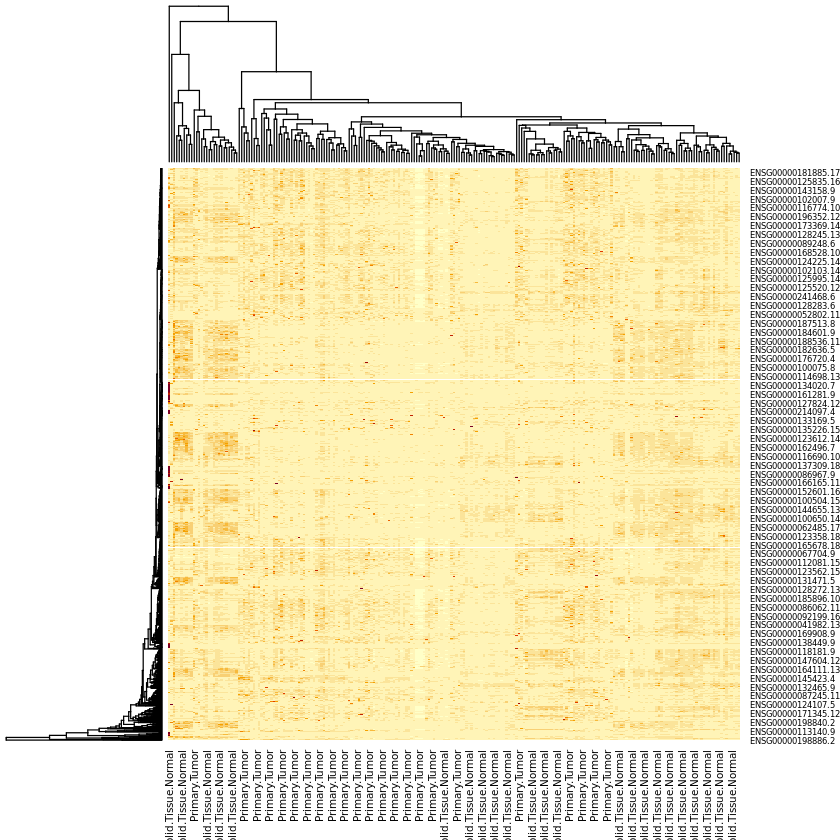

In [8]:
colnames(exp_matrix) <- split_df[[1]]$id
cases <- gsub('-', '.', split_df[[1]]$case_barcode)
str(cases)
sample_type <- gsub(' ', '.', split_df[[1]]$sample_type_name)
str(sample_type)
heatmap(as.matrix(exp_matrix), labCol=sample_type, scale="row")

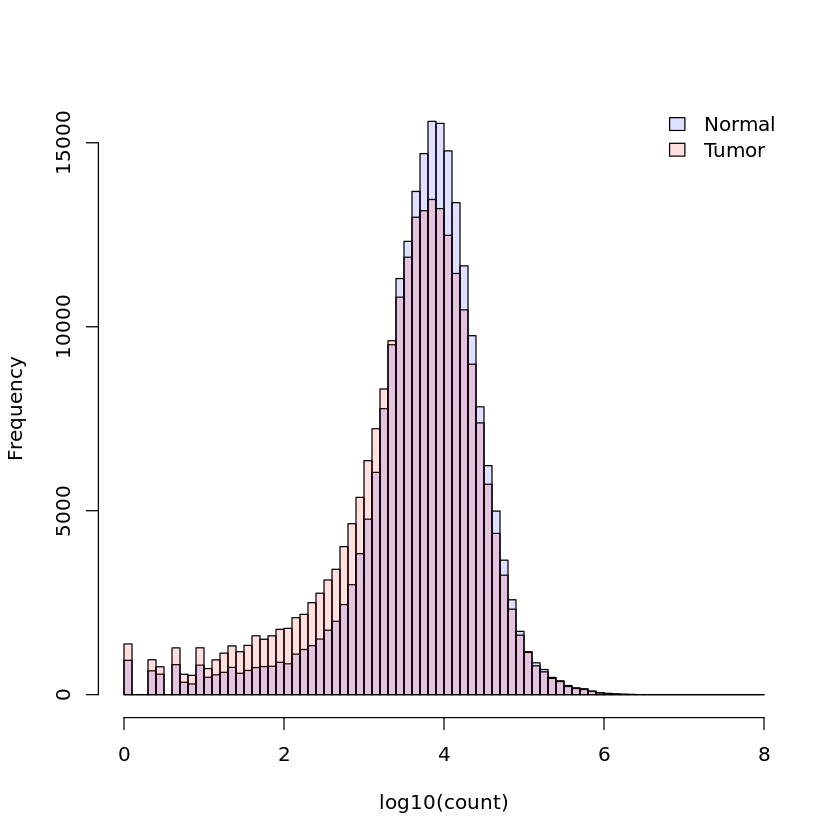

In [9]:
norm <- log10(unlist(exp_matrix[,which(sample_type == 'Solid.Tissue.Normal')]))
tumor <- log10(unlist(exp_matrix[,which(sample_type == 'Primary.Tumor')]))

p_norm <- hist(norm, breaks=seq(0,8,0.1), plot=0)
p_tumor <- hist(tumor, breaks=seq(0,8,0.1), plot=0)
plot( p_norm, col=rgb(0,0,1,1/8), xlim=c(0,8), xlab='log10(count)', main='')
plot( p_tumor, col=rgb(1,0,0,1/8), xlim=c(0,8), add=T)
legend("topright", legend=c("Normal", "Tumor"), fill=c(rgb(0,0,1,1/8), rgb(1,0,0,1/8)), bty="n") 

# Calculating differential expression using edgeR
We can now feed these data to edgeR, generate significance values of differential expression, and visualize the results using a scatterplot. Genes that fall below a 0.01 significance threshold are color coded red.

In [10]:
dge_obj <- DGEList(
             counts=exp_matrix, 
             lib.size=colSums(exp_matrix),
             samples=cases, 
             group=sample_type)
disp <- estimateDisp(dge_obj, method="pooled")
edgeR_test <- exactTest(disp)
results_df <- topTags(edgeR_test, nrow(exp_matrix))@.Data[[1]]
str(results_df)

Using classic mode.



'data.frame':	2000 obs. of  4 variables:
 $ logFC : num  2.9 -3.46 3.39 3.4 2.31 ...
 $ logCPM: num  9.59 12.91 6.49 6.24 11.34 ...
 $ PValue: num  1.35e-118 4.45e-115 6.04e-115 9.13e-107 1.41e-106 ...
 $ FDR   : num  2.70e-115 4.03e-112 4.03e-112 4.56e-104 5.63e-104 ...


[1] 1579

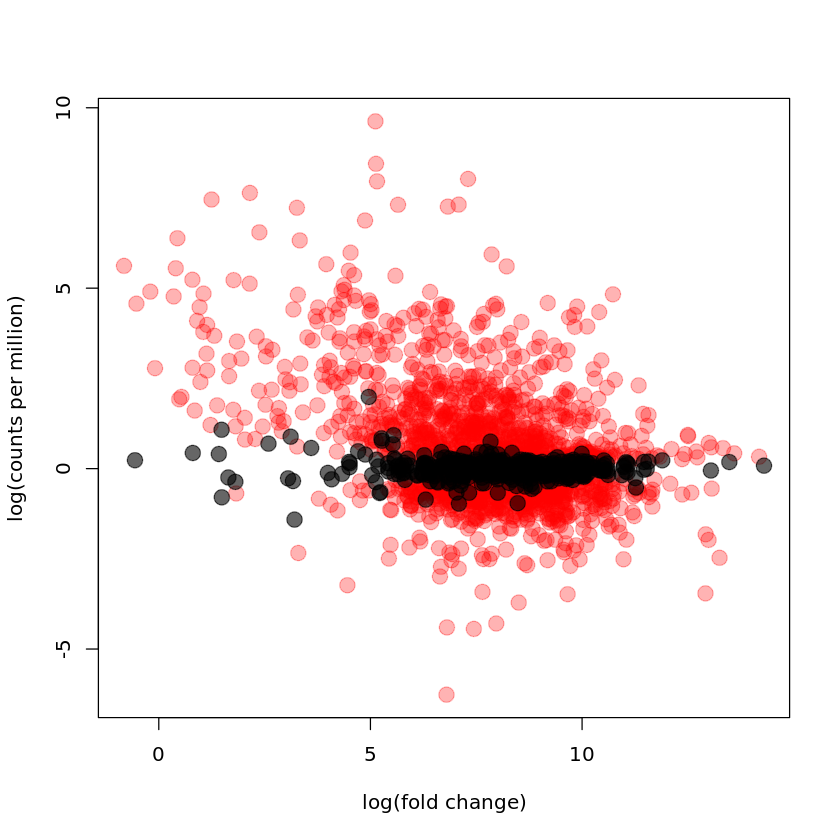

In [11]:
colors <- c(alpha('red', 0.3), alpha('black', 0.6))[(results_df$FDR > 0.01)+1]
plot(results_df$logCPM, results_df$logFC, 
     pch=19, cex=1.7, col=colors,
     xlab='log(fold change)', ylab='log(counts per million)')
sum(results_df$FDR <= 0.01)

In [12]:
col_info <- as.data.frame(cbind(cases, sample_type), stringAsFactors=TRUE)
deseq_obj <- DESeqDataSetFromMatrix( countData = exp_matrix, colData= col_info, design= ~ cases + sample_type)
deseq_output <- DESeq(deseq_obj, fitType='local')
summary(deseq_output)
deseq_results <- results(deseq_output)@listData

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

22 rows did not converge in beta, labelled in mcols(object)$betaConv. Use larger maxit argument with nbinomWaldTest



[1] "DESeqDataSet object of length 2000 with 466 metadata columns"

[1] 1595

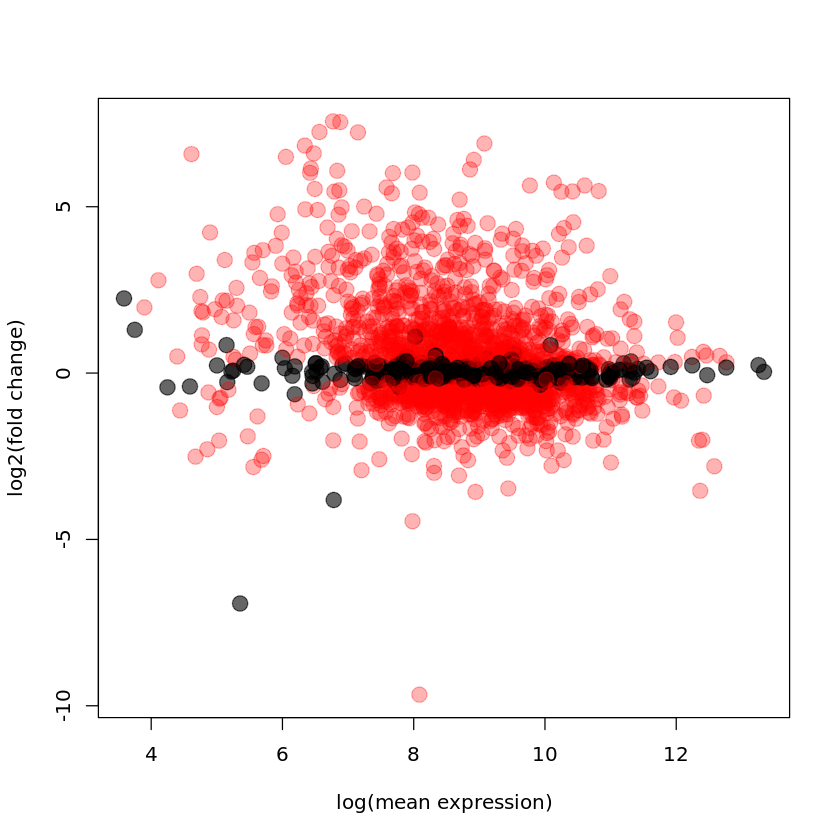

In [13]:
colors <- c(alpha('red', 0.3), alpha('black', 0.6))[(deseq_results$padj > 0.01)+1]
plot(log(deseq_results$baseMean), deseq_results$log2FoldChange, 
     pch=19, cex=1.7, col=colors,
     xlab='log(mean expression)', ylab='log2(fold change)')
sum(deseq_results$padj <= 0.01)

# Summary
It is quite simple to retrieve expression data from the GDC through the BQ ecosystem. These data can be subset and summarized easily via SQL queries and the results loaded into either R or Python for further analysis and visualization.